<a href="https://colab.research.google.com/github/antoronson/TF_Tutorials/blob/main/TF_TextClass_Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

6053168/6053168 [==============================] - 0s 0us/step
Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense

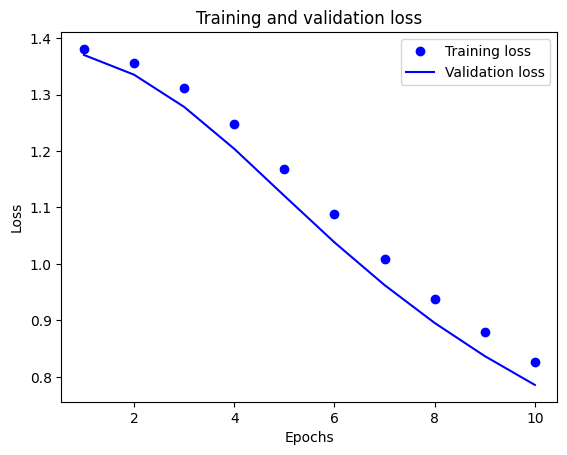

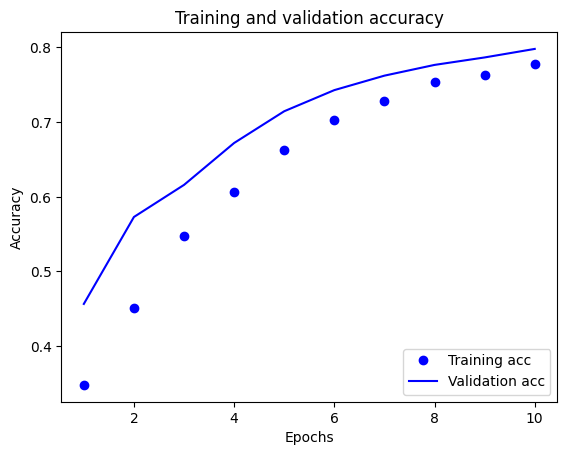

In [2]:
#TF_TextClassification_Exercise

#Decl
import tensorflow as tf
import os
import re
import shutil
import string
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses

url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                  untar = True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset))

#Show directories in data
#os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

os.listdir(train_dir)
#os.listdir(test_dir)
#pythondir = os.path.join(train_dir, 'python')
#os.listdir(pythondir)
"""
Read file data:
sample_file = os.path.join(train_dir, 'c/1234.txt')
with open(sample_file) as f:
  print(f.read())
"""

batch_size = 32 #TODO: Change and rerun later
seed = 42 #TODO: same as above

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size = batch_size
)


max_features = 10000
sequence_length = 250

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  #stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
#print("Review", first_review)
#print("Label", raw_train_ds.class_names[first_label])
#print("Vectorized review", vectorize_text(first_review, first_label))

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()


model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])


epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [5]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Review b'"what is the difference between these two ways to create an element? var a = document.createelement(\'div\');..a.id = ""mydiv"";...and..var a = document.createelement(\'div\').id = ""mydiv"";...what is the difference between them such that the first one works and the second one doesn\'t?"\n'
Label 2
Review b'"is it possible to add a static object to a list in blank? i have a bunch of static classes i would like to access easily by adding them all to a list...is there a way to add these static classes to a list? i get a ""this type is used like a variable"" error...public static class pcm1_setup : igui_to_bfc.{.    //pcm1_format.    public static void setup_tobfc().    {.        //uses the checkboxes to update the bfc.        //determine the value to write to the field based on the check boxes.        regmapinputreader.bitfield bf;.        gb.bfc.name_to_bitfield_dict.trygetvalue(""pcm1_format"", out bf);.    }..    public static void setup_frombfc().    {.        //sets up the

In [8]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 0.8613 - accuracy: 0.7391
0.7391250133514404


In [9]:
examples = [
    "system.console is returning wrong syntax"
]
export_model.predict(examples)

1/1 [==============================] - 0s 96ms/step


array([[0.5103551 , 0.45670545, 0.55995935, 0.459908  ]], dtype=float32)

In [14]:
examples = [
    "how to generate random numbers in python"
]
export_model.predict(examples)

1/1 [==============================] - 0s 38ms/step


array([[0.5230576 , 0.4645719 , 0.5408897 , 0.45911586]], dtype=float32)

In [11]:
for i in range(4):
  print ("Label", i, "Corresponds to ", raw_train_ds.class_names[i])

Label 0 Corresponds to  csharp
Label 1 Corresponds to  java
Label 2 Corresponds to  javascript
Label 3 Corresponds to  python
